<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Прогнозирование заказов такси на основе имеющихся данных таксопарка.

Целевая метрика - *RMSE* на тестовой выборке должно быть не больше 48.

Ход работы:

1. Загрузка данных и выполнение их ресемплирование по одному часу.
2. Проанализирование данные.
3. Обучение моделей с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error
from lightgbm import LGBMRegressor

In [2]:
orders = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
orders.sort_index(inplace = True)
orders

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [3]:
orders.info();

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [4]:
orders.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Данные корректные: пропусков нет, неадекватных значениц нет, явных дубликатов нет.

Временной интервал: 01 Марта 2018г - 31 Августа 2018г (6 полных месяца).

## Анализ

Ресемплирование до 1 дня:

In [6]:
data_1d = orders.resample('1D').sum()

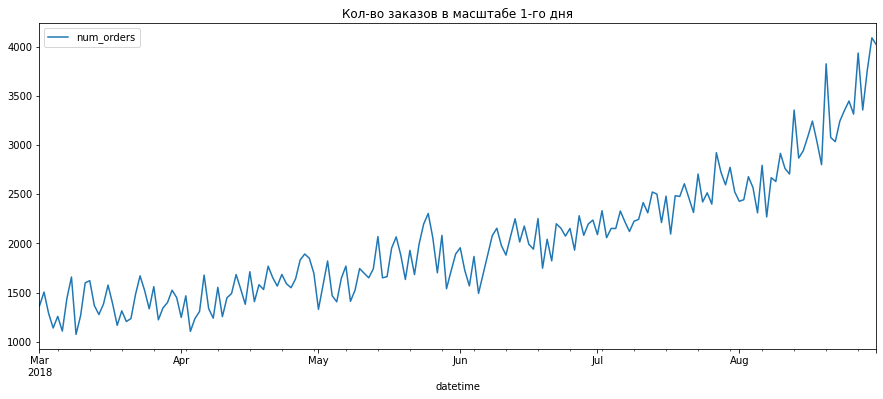

In [7]:
data_1d.plot(figsize=(15,6));
plt.title('Кол-во заказов в масштабе 1-го дня');

Скользящая средняя

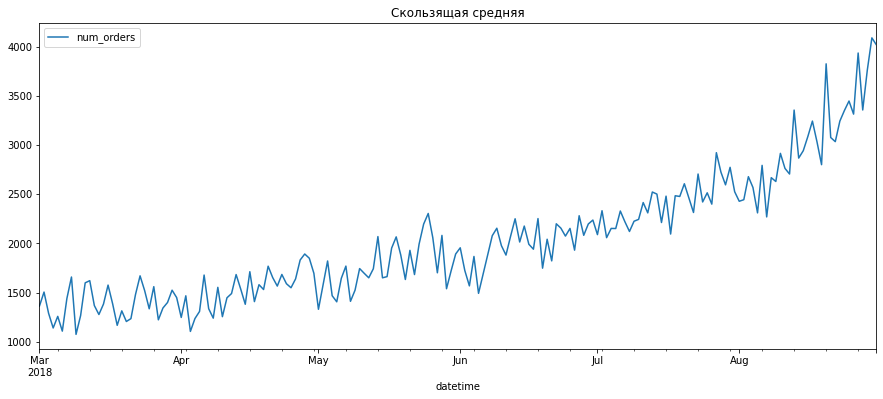

In [8]:
data_1d.rolling(10).mean()
data_1d.plot(figsize=(15,6));
plt.title('Скользящая средняя');

Сезонность и тренды

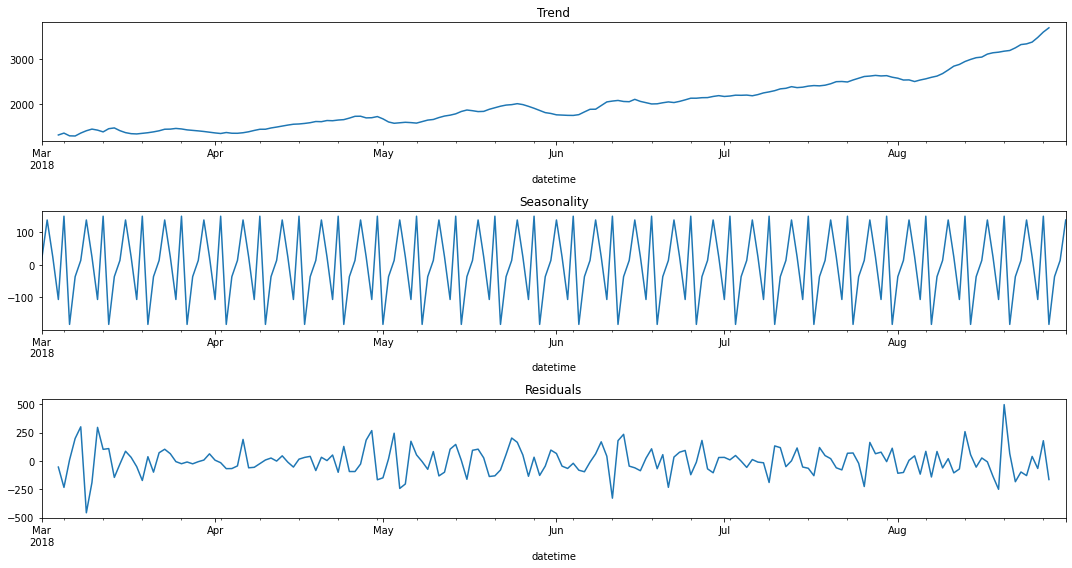

In [9]:
decomposed = seasonal_decompose(data_1d)
plt.figure(figsize=(15, 8))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Наблюдается явный растущий тренд на всём временном интревале.

Сезонность требует уменьшения исследуемого интервала.

По остатку видим всплески и провалы в праздничные дни (8 марта, май, 12 июня) и во второй половине августа (возможно отпуска, подготовка к началу учебного года).  

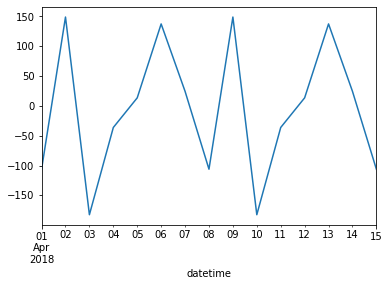

In [10]:
decomposed.seasonal['2018-04-01':'2018-04-15'].plot(ax=plt.gca());

Наблюдаем спад заказов по вторникам и воскресеньям, повышенную активность по понедельникам и пятницам.

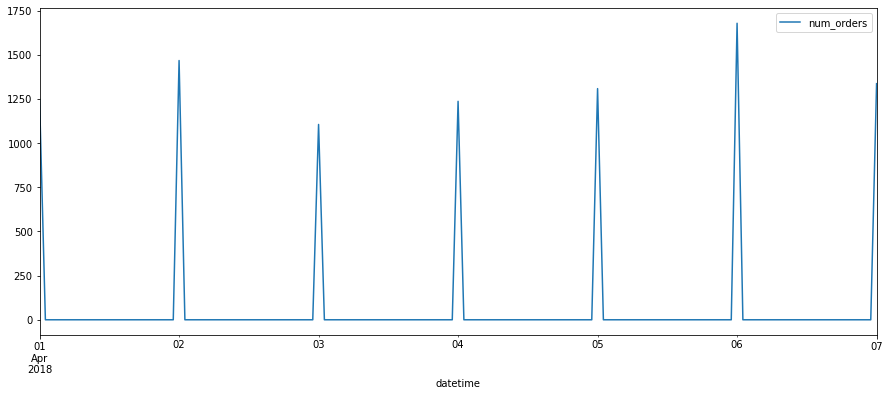

In [11]:
data_1d['2018-04-01':'2018-04-7'].resample('1H').sum().plot(figsize=(15,6));

Стационарность ряда:

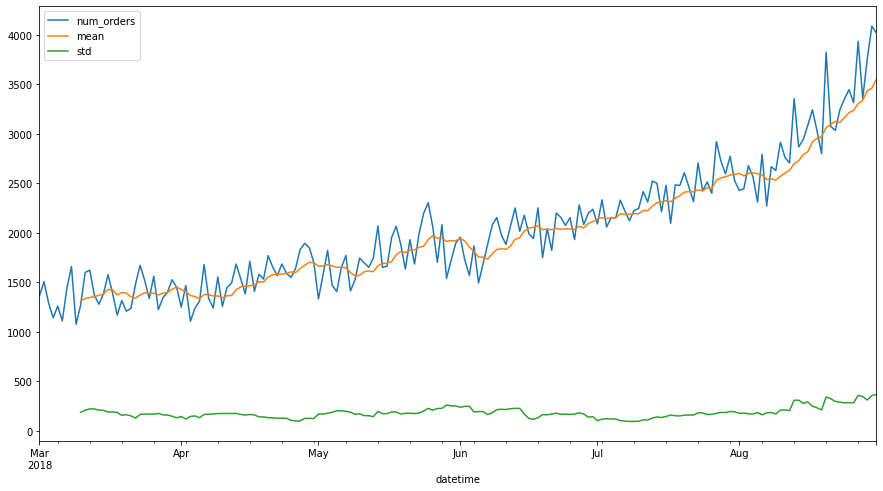

In [12]:
data_1d['mean'] = data_1d['num_orders'].rolling(10).mean()
data_1d['std'] = data_1d['num_orders'].rolling(10).std()
data_1d.plot(figsize=(15, 8));

Ряд нестационарный.

Строим разность временного ряда:

In [13]:
from statsmodels.tsa.stattools import adfuller

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()

ts = taxi['num_orders']
st_test = adfuller(ts, regression='ctt')

print('Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный')
if st_test[1] < 0.05:
    print('Наш ряд стационарный')
else:
    print('Ряд нестационарный')



Если значение с индексом 1 меньше P-Value, заданное нами (обычно берут 0.05), то ряд стационарный
Наш ряд стационарный


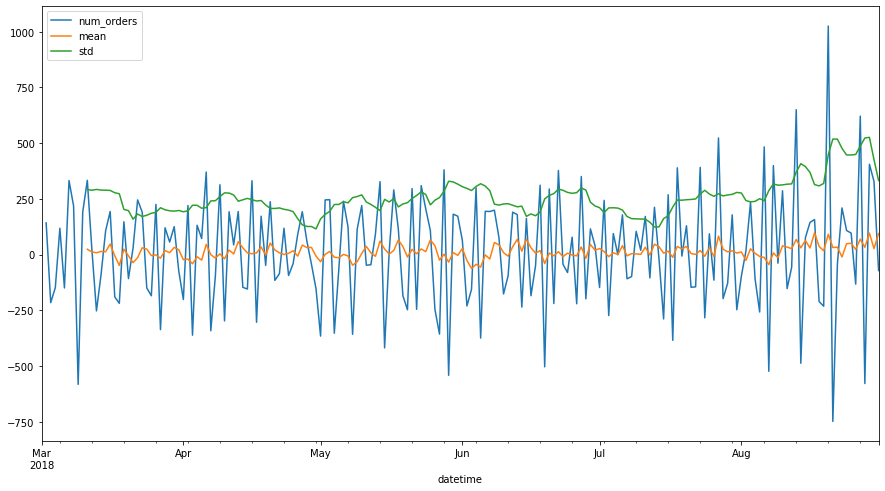

In [14]:
data_1d = data_1d - data_1d.shift()
data_1d['mean'] = data_1d['num_orders'].rolling(10).mean()
data_1d['std'] = data_1d['num_orders'].rolling(10).std()
data_1d.plot(figsize=(15, 8));

## Обучение

In [15]:
orders = orders.resample('1H').sum() #дневной интервал

Создание признаков:

In [16]:
def make_features(orders, max_lag, rolling_mean_size):
    #orders['year'] = orders.index.year
    #orders['month'] = orders.index.month
    orders['hour'] = orders.index.hour
    orders['day'] = orders.index.day
    orders['dayofweek'] = orders.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        orders['lag_{}'.format(lag)] = orders['num_orders'].shift(lag)

    orders['rolling_mean'] = orders['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(orders, 168, 24)
#print(orders.head())

In [17]:
display(orders)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,1,3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,1,3,124.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,1,3,85.0,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,71.0,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,1,3,66.0,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,164.875000
2018-08-31 20:00:00,154,20,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,167.541667
2018-08-31 21:00:00,159,21,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,168.041667


In [18]:
train, test = train_test_split(orders, shuffle=False, test_size=0.1)
train = train.dropna()
display(train)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,143,0,8,3,94.0,127.0,108.0,76.0,50.0,99.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,78,1,8,3,143.0,94.0,127.0,108.0,76.0,50.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,65,2,8,3,78.0,143.0,94.0,127.0,108.0,76.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,68,3,8,3,65.0,78.0,143.0,94.0,127.0,108.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,60,4,8,3,68.0,65.0,78.0,143.0,94.0,127.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-13 09:00:00,137,9,13,0,91.0,39.0,66.0,83.0,143.0,168.0,...,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,136.0,134.041667
2018-08-13 10:00:00,156,10,13,0,137.0,91.0,39.0,66.0,83.0,143.0,...,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,124.0,135.250000
2018-08-13 11:00:00,144,11,13,0,156.0,137.0,91.0,39.0,66.0,83.0,...,104.0,85.0,133.0,204.0,117.0,98.0,104.0,87.0,131.0,137.250000


In [19]:
display(test)

,num_orders,hour,day,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-13 14:00:00,102,14,13,0,119.0,92.0,144.0,156.0,137.0,91.0,...,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,98.0,138.541667
2018-08-13 15:00:00,175,15,13,0,102.0,119.0,92.0,144.0,156.0,137.0,...,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,117.0,138.458333
2018-08-13 16:00:00,144,16,13,0,175.0,102.0,119.0,92.0,144.0,156.0,...,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,204.0,139.541667
2018-08-13 17:00:00,152,17,13,0,144.0,175.0,102.0,119.0,92.0,144.0,...,101.0,156.0,119.0,101.0,98.0,67.0,104.0,85.0,133.0,139.166667
2018-08-13 18:00:00,104,18,13,0,152.0,144.0,175.0,102.0,119.0,92.0,...,125.0,101.0,156.0,119.0,101.0,98.0,67.0,104.0,85.0,140.708333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,19,31,4,207.0,217.0,197.0,116.0,133.0,166.0,...,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,113.0,164.875000
2018-08-31 20:00:00,154,20,31,4,136.0,207.0,217.0,197.0,116.0,133.0,...,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,179.0,167.541667
2018-08-31 21:00:00,159,21,31,4,154.0,136.0,207.0,217.0,197.0,116.0,...,118.0,196.0,187.0,160.0,246.0,273.0,173.0,242.0,166.0,168.041667


In [20]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [21]:
features_train= train.drop(['num_orders'], axis=1) 
features_test= test.drop(['num_orders'], axis=1) 
target_train = train['num_orders']
target_test = test['num_orders']

model = LinearRegression()
model.fit(features_train, target_train)

prediction_train= model.predict(features_train)
prediction_test= model.predict(features_test)
print("RMSE обучающей выборки лин. регресси:", mean_squared_error(target_train, prediction_train)**0.5)
print("RMSE тестовой выборки лин. регресси:", mean_squared_error(target_test, prediction_test)**0.5)

RMSE обучающей выборки лин. регресси: 20.36356497660353
RMSE тестовой выборки лин. регресси: 34.5607186951862


In [22]:
%%time
#модель линейной регрессии
cv = TimeSeriesSplit(n_splits=3).split(features_train)
model_lr = LinearRegression() 
model_lr.fit(features_train, target_train)
score_lr = cross_val_score(model_lr, features_train, target_train, scoring='neg_mean_squared_error', cv=cv)
round(np.mean(-score_lr)**0.5, 2)

CPU times: user 1.23 s, sys: 1.47 s, total: 2.69 s
Wall time: 2.7 s


23.2

Модель Дерево решений:

In [23]:
model_dt= DecisionTreeRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(20,30)
}
gsearch = GridSearchCV(model_dt, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
dt_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE модели дерева решений: {-dt_model.best_score_} при параметрах {dt_model.best_params_}')

Лучшая RMSE модели дерева решений: 26.60549600443208 при параметрах {'max_depth': 15, 'min_samples_leaf': 27}


In [24]:
model_rf= RandomForestRegressor(random_state=12345)
param_grid = {
    "max_depth" : range(15,16),
    "min_samples_leaf" : range(2,3)
}
gsearch = GridSearchCV(model_rf, param_grid = param_grid, scoring='neg_root_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))
rf_model = gsearch.fit(features_train,target_train)
print(f'Лучшая RMSE модели случайный лес: {-rf_model.best_score_} при параметрах ,{rf_model.best_params_}')

Лучшая RMSE модели случайный лес: 22.911451113215715 при параметрах ,{'max_depth': 15, 'min_samples_leaf': 2}


Модель LGBM:

In [25]:
model_LGBM = LGBMRegressor(num_leaves= 31,learning_rate=0.1)

parameters = {
    'n_estimators': [50,100,250],
    'max_depth': [5,15,20]   
}

grid = GridSearchCV(model_LGBM, parameters, scoring='neg_mean_squared_error', cv=TimeSeriesSplit(n_splits=5))

lgb_model = grid.fit(features_train, target_train)

print('Лучшие параметры:', grid.best_params_)
print('Лучшее значение:', (-1*(grid.best_score_))**0.5)

Лучшие параметры: {'max_depth': 15, 'n_estimators': 50}
Лучшее значение: 23.09492953735093


Лучшая модель LightGBM c лучшими параметрами обеспечивает RMSE = 23 при скользящей средней = 24 и лагом = 168.

## Тестирование

In [29]:
dt_model_test = dt_model.fit(features_train,target_train)
dt_predictions = dt_model_test.predict(features_test)
RSME_dt_test = mean_squared_error(target_test, dt_predictions,squared= False)

rf_model_test = rf_model.fit(features_train,target_train)
rf_predictions = rf_model_test.predict(features_test)
RSME_rf_test = mean_squared_error(target_test, rf_predictions,squared= False)


lr_model_test = model_lr.fit(features_train,target_train)
lr_predictions = lr_model_test.predict(features_test)
RSME_lr_test = mean_squared_error(target_test, lr_predictions,squared= False)

lgb_model_test = lgb_model.fit(features_train,target_train)
lgb_predictions = lgb_model_test.predict(features_test)
RSME_lgb_test = mean_squared_error(target_test, lgb_predictions,squared= False)

print(RSME_dt_test,RSME_rf_test,RSME_lr_test,RSME_lgb_test)

43.896494132488634 38.65478030340361 34.5607186951862 36.88620555414358


ИТОГ:

- проведен анализ данных и выбраны признаки для прогнозирования целевого признака на нестационарном временном ряду
- построены модели с перебором параметров при скользящей средней = 24 и лагом = 168. 
- наиболее эффективная модель - модель линейной регрессии со значением RMSE = 34.6 (ниже пороговой = 48)

Допополнительно. Проверка корреляции для выбора нужного лага.

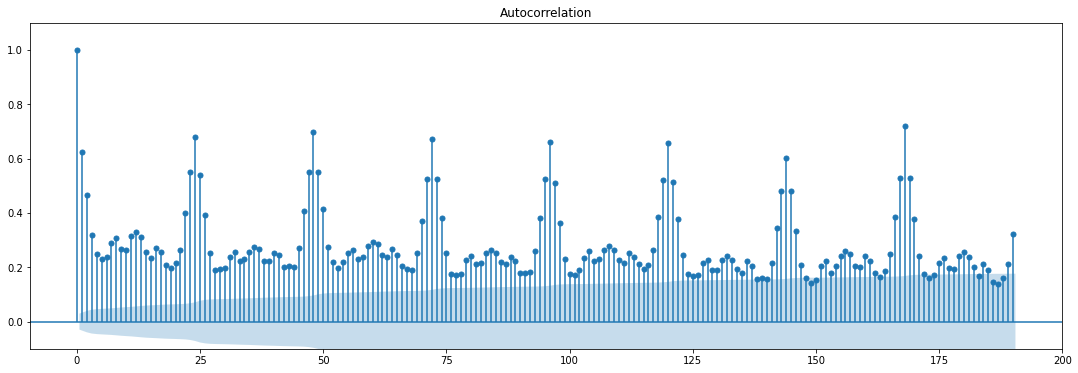

In [27]:
from statsmodels.graphics import tsaplots

taxi = pd.read_csv("/datasets/taxi.csv", index_col=[0], parse_dates=[0]).resample('1H').sum()
ts = taxi['num_orders']

fig = tsaplots.plot_acf(ts,lags= 190)
fig.set_size_inches(18.5, 6)
plt.ylim(-.1, 1.1)
plt.show() 

